In [1]:
 !pip install kaggle
 from google.colab import files
 uploaded = files.upload()

 for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(
       name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
 !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:
import os
kaggle_username = "sartajbhuvaji"
kaggle_dataset = "brain-tumor-classification-mri"

try: 
  os.mkdir("data")
  os.chdir("data")
  os.system(" kaggle datasets download " + kaggle_username + "/" + kaggle_dataset)
  os.system(" unzip "+ kaggle_dataset)
  os.chdir("..")
except OSError as error:
  print("Carpeta existente")


#kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

In [3]:
import pathlib
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Tarjetas detectadas:" + str(len(gpu_devices)))
if len(gpu_devices) > 0:
  tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  #print("GPUs: " + gpu_devices[0])

  gpus = tf.test.gpu_device_name()
  print("Estatus tarjetas GPU:" + str(len(gpu_devices)) + " detectadas")
else:
  print("Estatus tarjetas GPU: No detectadas")

Tarjetas detectadas:1
Estatus tarjetas GPU:1 detectadas


In [6]:
data_dir_train = pathlib.Path("data/Training")
data_dir_test = pathlib.Path("data/Testing")

In [7]:
print((data_dir_test),' ' ,(data_dir_train))

data/Testing   data/Training


data/Training/glioma_tumor/gg (117).jpg
widht: 512
height: 512


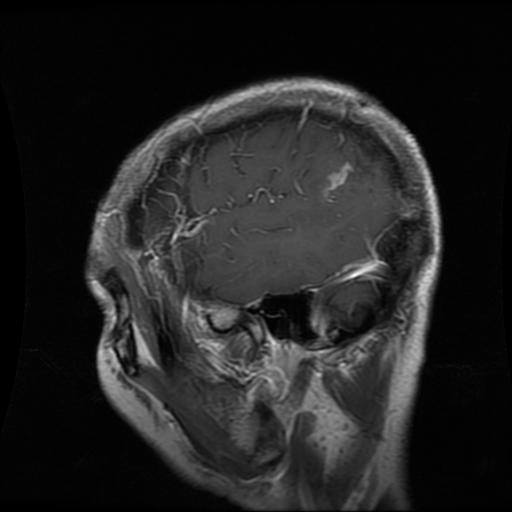

In [8]:
images = list(data_dir_train.glob('**/*.jpg'))
print(images[2])
img = PIL.Image.open(str(images[2]))
width, height = img.size
print('widht: ' + str(width))
print('height: '+ str(height)) 
PIL.Image.open(str(images[2]))

In [9]:
batch_size = 32
img_height = 254
img_width = 254


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)



Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


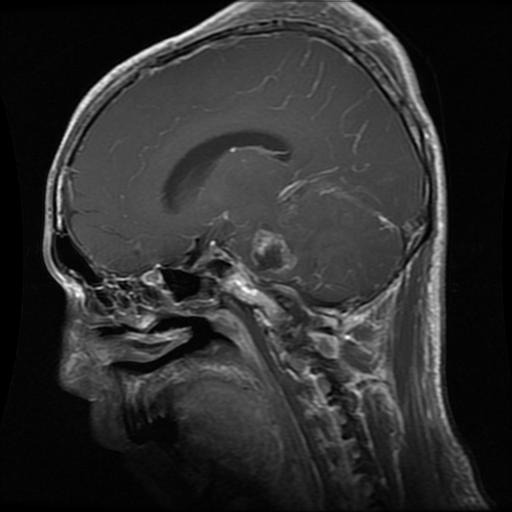

In [10]:
glioma_tumor = list(data_dir_train.glob('glioma_tumor/*'))
PIL.Image.open(str(glioma_tumor[4]))

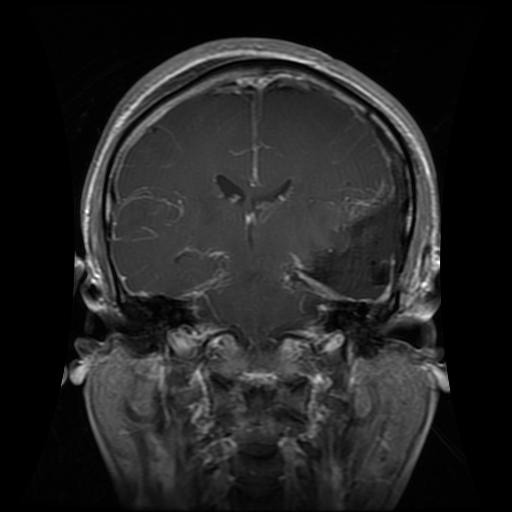

In [11]:
PIL.Image.open(str(glioma_tumor[1]))

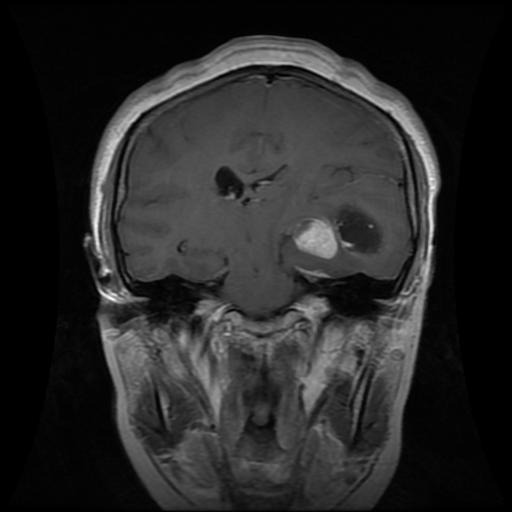

In [12]:
meningioma_tumor = list(data_dir_train.glob('meningioma_tumor/*'))
PIL.Image.open(str(meningioma_tumor[0]))

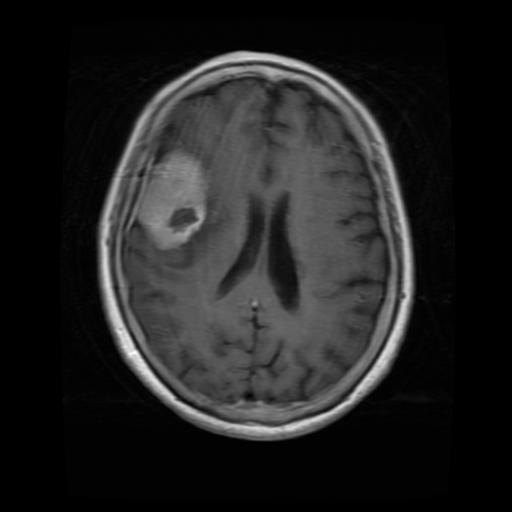

In [13]:
PIL.Image.open(str(meningioma_tumor[1]))

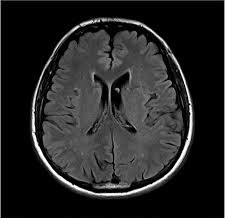

In [14]:
no_tumor = list(data_dir_train.glob('no_tumor/*'))
PIL.Image.open(str(no_tumor[0]))

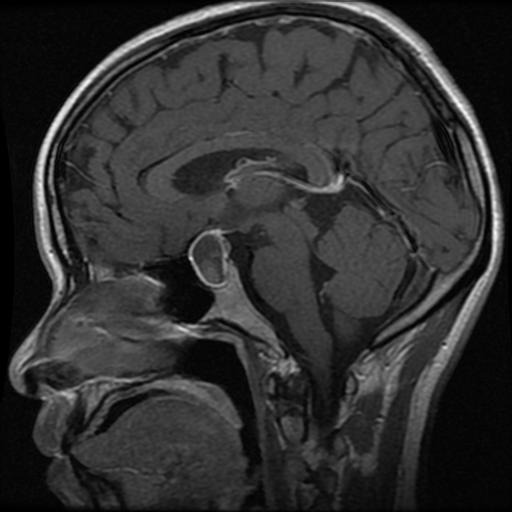

In [15]:
pituitary_tumor = list(data_dir_train.glob('pituitary_tumor/*'))
PIL.Image.open(str(pituitary_tumor[15]))

In [16]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [17]:
class_names = test_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


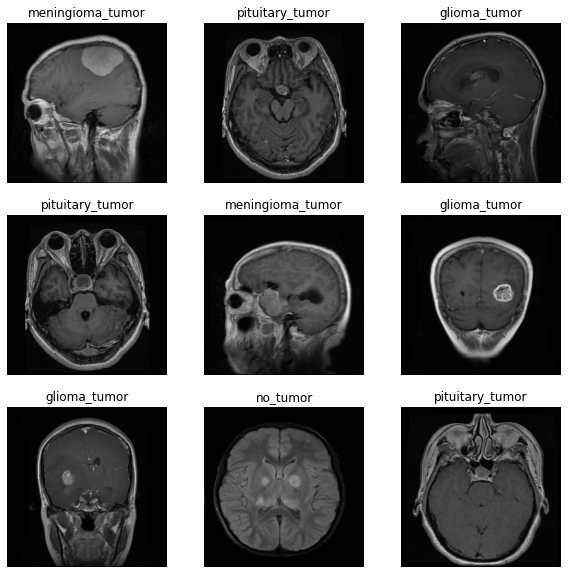

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 254, 254, 3)
(32,)


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.84640163


In [23]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0

In [26]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 38s 56ms/step - loss: 1.2923 - accuracy: 0.4896 - val_loss: 0.6350 - val_accuracy: 0.7307
Epoch 2/20
90/90 [==============================] - 4s 47ms/step - loss: 0.5689 - accuracy: 0.7616 - val_loss: 0.3408 - val_accuracy: 0.8920
Epoch 3/20
90/90 [==============================] - 4s 48ms/step - loss: 0.3658 - accuracy: 0.8571 - val_loss: 0.2092 - val_accuracy: 0.9408
Epoch 4/20
90/90 [==============================] - 4s 48ms/step - loss: 0.1974 - accuracy: 0.9400 - val_loss: 0.1301 - val_accuracy: 0.9725
Epoch 5/20
90/90 [==============================] - 4s 48ms/step - loss: 0.1412 - accuracy: 0.9631 - val_loss: 0.0972 - val_accuracy: 0.9798
Epoch 6/20
90/90 [==============================] - 4s 48ms/step - loss: 0.1146 - accuracy: 0.9673 - val_loss: 0.0575 - val_accuracy: 0.9916
Epoch 7/20
90/90 [==============================] - 4s 48ms/step - loss: 0.0611 - accuracy: 0.9854 - val_loss: 0.0401 - val_accuracy: 0.9944
Epoch 8/20
9

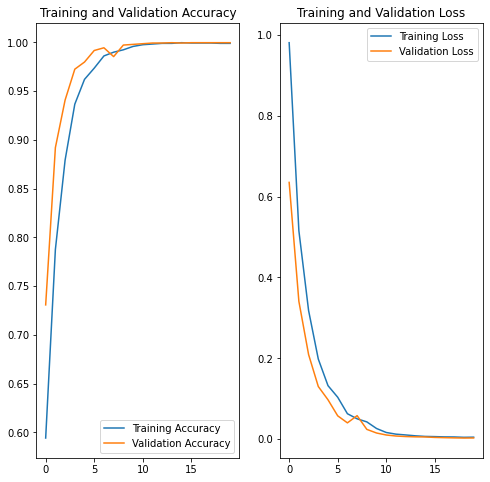

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model.png')

In [132]:
img = keras.preprocessing.image.load_img(
    '/content/image(100)_men.jpg', target_size=(img_height, img_width)
)


img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to meningioma_tumor with a 81.19 percent confidence.


In [133]:
img = keras.preprocessing.image.load_img(
    '/content/oligodendroglioma_low_grade_high_es.jpg', target_size=(img_height, img_width)
)


img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to meningioma_tumor with a 94.78 percent confidence.


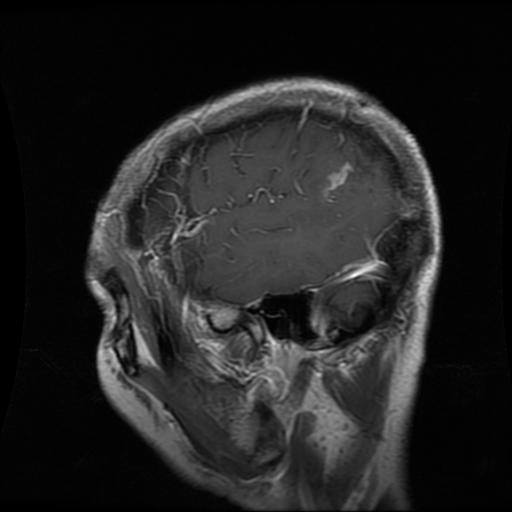

In [29]:
img

Variación 1:  aumentar el numero de capas de convolución y maxpooling

In [30]:
model_1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Flatten(),
  #layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [33]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 84, 84, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)       

In [35]:
epochs=20
history = model_1.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 4s 40ms/step - loss: 1.1692 - accuracy: 0.4723 - val_loss: 0.7958 - val_accuracy: 0.6930
Epoch 2/20
90/90 [==============================] - 3s 36ms/step - loss: 0.7535 - accuracy: 0.6931 - val_loss: 0.5127 - val_accuracy: 0.7983
Epoch 3/20
90/90 [==============================] - 3s 36ms/step - loss: 0.5298 - accuracy: 0.7933 - val_loss: 0.3909 - val_accuracy: 0.8610
Epoch 4/20
90/90 [==============================] - 3s 36ms/step - loss: 0.4036 - accuracy: 0.8422 - val_loss: 0.4121 - val_accuracy: 0.8429
Epoch 5/20
90/90 [==============================] - 3s 36ms/step - loss: 0.3308 - accuracy: 0.8826 - val_loss: 0.1950 - val_accuracy: 0.9397
Epoch 6/20
90/90 [==============================] - 3s 36ms/step - loss: 0.2245 - accuracy: 0.9182 - val_loss: 0.1694 - val_accuracy: 0.9348
Epoch 7/20
90/90 [==============================] - 3s 37ms/step - loss: 0.2295 - accuracy: 0.9172 - val_loss: 0.1128 - val_accuracy: 0.9662
Epoch 8/20
90

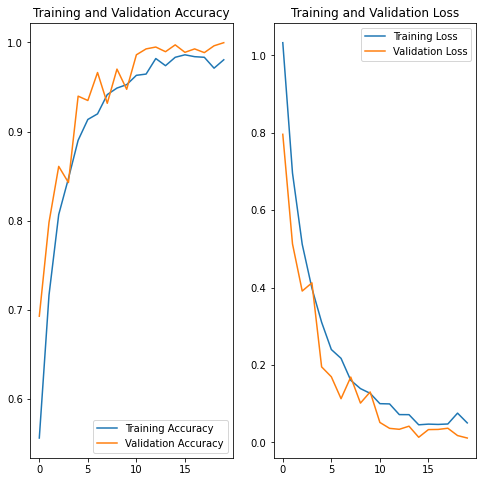

<Figure size 432x288 with 0 Axes>

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_1.png')

Variacion 1.2: Aumentar capas de maxpooling

In [37]:
model_2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Flatten(),
  #layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [38]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 64)         

In [40]:
epochs=20
history = model_2.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 3s 31ms/step - loss: 1.2665 - accuracy: 0.3894 - val_loss: 1.0423 - val_accuracy: 0.5481
Epoch 2/20
90/90 [==============================] - 3s 29ms/step - loss: 0.9203 - accuracy: 0.6132 - val_loss: 0.7245 - val_accuracy: 0.6976
Epoch 3/20
90/90 [==============================] - 3s 28ms/step - loss: 0.7496 - accuracy: 0.6998 - val_loss: 0.6348 - val_accuracy: 0.7526
Epoch 4/20
90/90 [==============================] - 3s 28ms/step - loss: 0.6580 - accuracy: 0.7229 - val_loss: 0.5287 - val_accuracy: 0.7794
Epoch 5/20
90/90 [==============================] - 3s 29ms/step - loss: 0.5528 - accuracy: 0.7776 - val_loss: 0.4536 - val_accuracy: 0.8348
Epoch 6/20
90/90 [==============================] - 3s 29ms/step - loss: 0.4933 - accuracy: 0.8122 - val_loss: 0.4216 - val_accuracy: 0.8429
Epoch 7/20
90/90 [==============================] - 3s 29ms/step - loss: 0.4296 - accuracy: 0.8374 - val_loss: 0.3467 - val_accuracy: 0.8847
Epoch 8/20
90

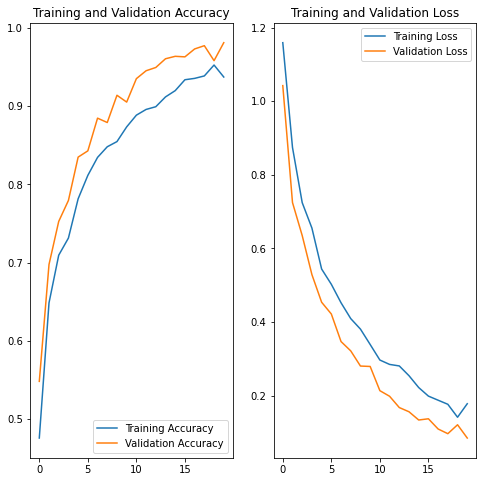

<Figure size 432x288 with 0 Axes>

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_2.png')

In [44]:
model_3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Flatten(),
  #layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [45]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 84, 84, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 3, 3, 32)         

In [131]:
epochs=20
history = model_3.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
45/45 [==============================] - 15s 306ms/step - loss: 1.3213 - accuracy: 0.3683 - val_loss: 1.2679 - val_accuracy: 0.4272
Epoch 2/20
45/45 [==============================] - 14s 301ms/step - loss: 1.1826 - accuracy: 0.4805 - val_loss: 1.0238 - val_accuracy: 0.5763
Epoch 3/20
45/45 [==============================] - 14s 300ms/step - loss: 0.9573 - accuracy: 0.6031 - val_loss: 0.8846 - val_accuracy: 0.5983
Epoch 4/20
45/45 [==============================] - 14s 302ms/step - loss: 0.8156 - accuracy: 0.6854 - val_loss: 0.7417 - val_accuracy: 0.7387
Epoch 5/20
45/45 [==============================] - 14s 299ms/step - loss: 0.7328 - accuracy: 0.7063 - val_loss: 0.6313 - val_accuracy: 0.7439
Epoch 6/20
45/45 [==============================] - 14s 301ms/step - loss: 0.6433 - accuracy: 0.7453 - val_loss: 0.6139 - val_accuracy: 0.7798
Epoch 7/20
45/45 [==============================] - 14s 303ms/step - loss: 0.5884 - accuracy: 0.7676 - val_loss: 0.5865 - val_accuracy: 0.7749

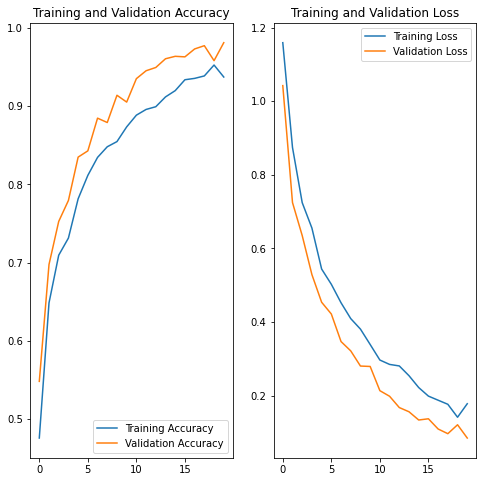

<Figure size 432x288 with 0 Axes>

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_3.png')

Variación 2: Cambiar la dimensionalidad de las matrices de convolución y pooling (por ejemplo si se usaba 3x3 para convolución y 2x2 para maxpolling cambiar a 4x4 y 3x3) 

In [53]:
model_4= Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D((3,3)),
  layers.Conv2D(64, (4,4), padding='same', activation='relu'),
  layers.MaxPooling2D((3,3)),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [49]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 254, 254, 16)      784       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 127, 127, 32)      8224      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 42, 42, 64)        32832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 64)       

In [51]:
epochs=20
history = model_4.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 6s 58ms/step - loss: 1.1624 - accuracy: 0.4745 - val_loss: 0.6724 - val_accuracy: 0.7233
Epoch 2/20
90/90 [==============================] - 5s 53ms/step - loss: 0.5891 - accuracy: 0.7480 - val_loss: 0.3784 - val_accuracy: 0.8634
Epoch 3/20
90/90 [==============================] - 5s 53ms/step - loss: 0.4213 - accuracy: 0.8331 - val_loss: 0.3131 - val_accuracy: 0.8847
Epoch 4/20
90/90 [==============================] - 5s 54ms/step - loss: 0.3032 - accuracy: 0.8879 - val_loss: 0.2493 - val_accuracy: 0.9042
Epoch 5/20
90/90 [==============================] - 5s 54ms/step - loss: 0.2388 - accuracy: 0.9116 - val_loss: 0.1391 - val_accuracy: 0.9686
Epoch 6/20
90/90 [==============================] - 5s 54ms/step - loss: 0.1498 - accuracy: 0.9607 - val_loss: 0.1008 - val_accuracy: 0.9739
Epoch 7/20
90/90 [==============================] - 5s 54ms/step - loss: 0.1345 - accuracy: 0.9541 - val_loss: 0.0731 - val_accuracy: 0.9843
Epoch 8/20
90

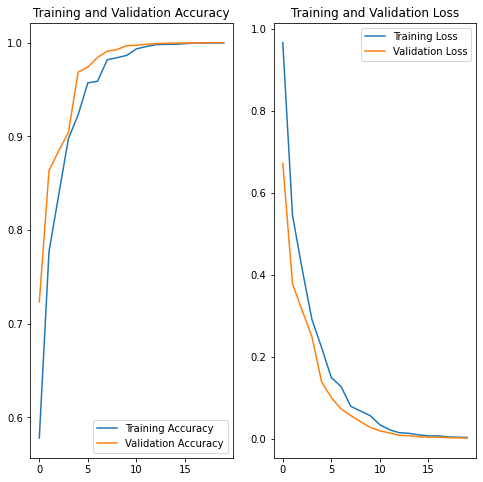

<Figure size 432x288 with 0 Axes>

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_4.png')

Variación 3: Probar al menos 2 opciones diferentes de optimizer

Usando ADAMAX


In [54]:
model_5 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [56]:
model_5.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 64)       

In [59]:
epochs=20
history = model_5.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 5s 50ms/step - loss: 1.1295 - accuracy: 0.5244 - val_loss: 0.6208 - val_accuracy: 0.7547
Epoch 2/20
90/90 [==============================] - 4s 48ms/step - loss: 0.5837 - accuracy: 0.7451 - val_loss: 0.4297 - val_accuracy: 0.8439
Epoch 3/20
90/90 [==============================] - 4s 48ms/step - loss: 0.4501 - accuracy: 0.8044 - val_loss: 0.3342 - val_accuracy: 0.8794
Epoch 4/20
90/90 [==============================] - 4s 48ms/step - loss: 0.3489 - accuracy: 0.8698 - val_loss: 0.2456 - val_accuracy: 0.9303
Epoch 5/20
90/90 [==============================] - 4s 48ms/step - loss: 0.2745 - accuracy: 0.9115 - val_loss: 0.2189 - val_accuracy: 0.9286
Epoch 6/20
90/90 [==============================] - 4s 49ms/step - loss: 0.2127 - accuracy: 0.9335 - val_loss: 0.1654 - val_accuracy: 0.9547
Epoch 7/20
90/90 [==============================] - 4s 49ms/step - loss: 0.1691 - accuracy: 0.9458 - val_loss: 0.1223 - val_accuracy: 0.9732
Epoch 8/20
90

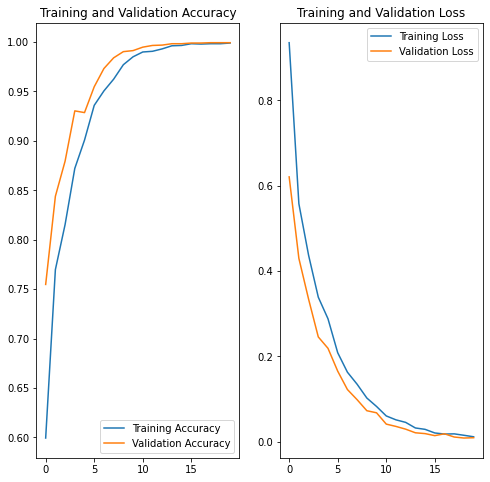

<Figure size 432x288 with 0 Axes>

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_5.png')

Usando ADADELTA

In [97]:
model_6 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [98]:
from keras.optimizers import Adadelta

In [99]:
model_6.compile(optimizer= 'AdaDelta',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [100]:
model_6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 31, 31, 64)       

In [101]:
epochs=20
history = model_6.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 5s 50ms/step - loss: 1.5879 - accuracy: 0.2560 - val_loss: 1.4759 - val_accuracy: 0.2878
Epoch 2/20
90/90 [==============================] - 4s 48ms/step - loss: 1.5070 - accuracy: 0.2654 - val_loss: 1.3951 - val_accuracy: 0.2878
Epoch 3/20
90/90 [==============================] - 4s 48ms/step - loss: 1.4208 - accuracy: 0.2820 - val_loss: 1.3404 - val_accuracy: 0.3042
Epoch 4/20
90/90 [==============================] - 4s 48ms/step - loss: 1.3780 - accuracy: 0.3333 - val_loss: 1.3079 - val_accuracy: 0.4735
Epoch 5/20
90/90 [==============================] - 4s 48ms/step - loss: 1.3365 - accuracy: 0.3741 - val_loss: 1.2886 - val_accuracy: 0.5171
Epoch 6/20
90/90 [==============================] - 4s 48ms/step - loss: 1.3316 - accuracy: 0.3767 - val_loss: 1.2738 - val_accuracy: 0.5341
Epoch 7/20
90/90 [==============================] - 4s 48ms/step - loss: 1.3034 - accuracy: 0.3989 - val_loss: 1.2608 - val_accuracy: 0.5463
Epoch 8/20
90

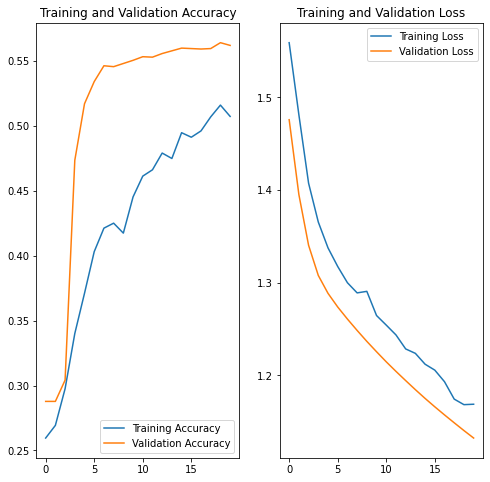

<Figure size 432x288 with 0 Axes>

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_6.png')

Usando ADAGRAD

In [103]:
model_7 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [104]:
model_7.compile(optimizer= 'Adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [105]:
model_7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 31, 64)       

In [106]:
epochs=20
history = model_7.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
90/90 [==============================] - 5s 50ms/step - loss: 1.4698 - accuracy: 0.2621 - val_loss: 1.3440 - val_accuracy: 0.3672
Epoch 2/20
90/90 [==============================] - 4s 48ms/step - loss: 1.3922 - accuracy: 0.3126 - val_loss: 1.3164 - val_accuracy: 0.4564
Epoch 3/20
90/90 [==============================] - 4s 47ms/step - loss: 1.3511 - accuracy: 0.3400 - val_loss: 1.2708 - val_accuracy: 0.5045
Epoch 4/20
90/90 [==============================] - 4s 47ms/step - loss: 1.2884 - accuracy: 0.4162 - val_loss: 1.1868 - val_accuracy: 0.5355
Epoch 5/20
90/90 [==============================] - 4s 48ms/step - loss: 1.2040 - accuracy: 0.4568 - val_loss: 1.1040 - val_accuracy: 0.5401
Epoch 6/20
90/90 [==============================] - 4s 47ms/step - loss: 1.1140 - accuracy: 0.5300 - val_loss: 1.0383 - val_accuracy: 0.5599
Epoch 7/20
90/90 [==============================] - 4s 48ms/step - loss: 1.0605 - accuracy: 0.5423 - val_loss: 0.9776 - val_accuracy: 0.5770
Epoch 8/20
90

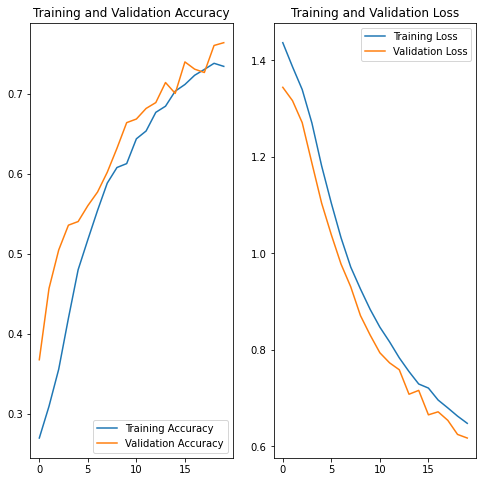

<Figure size 432x288 with 0 Axes>

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_7.png')

Variación 4: Cambio de Batch size

Batch size = 10

In [115]:
batch_size = 10


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)



Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [116]:
model_8 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [117]:
model_8.compile(optimizer= 'Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [118]:
model_8.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 31, 31, 64)      

In [119]:
epochs=20
history = model_8.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
287/287 [==============================] - 18s 61ms/step - loss: 0.9824 - accuracy: 0.5722 - val_loss: 0.4373 - val_accuracy: 0.8132
Epoch 2/20
287/287 [==============================] - 18s 63ms/step - loss: 0.4445 - accuracy: 0.8094 - val_loss: 0.2036 - val_accuracy: 0.9279
Epoch 3/20
287/287 [==============================] - 18s 63ms/step - loss: 0.2159 - accuracy: 0.9079 - val_loss: 0.0984 - val_accuracy: 0.9714
Epoch 4/20
287/287 [==============================] - 18s 63ms/step - loss: 0.1067 - accuracy: 0.9672 - val_loss: 0.0495 - val_accuracy: 0.9854
Epoch 5/20
287/287 [==============================] - 18s 63ms/step - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0182 - val_accuracy: 0.9976
Epoch 6/20
287/287 [==============================] - 18s 63ms/step - loss: 0.0237 - accuracy: 0.9961 - val_loss: 0.0112 - val_accuracy: 0.9979
Epoch 7/20
287/287 [==============================] - 18s 62ms/step - loss: 0.0106 - accuracy: 0.9995 - val_loss: 0.0054 - val_accuracy:

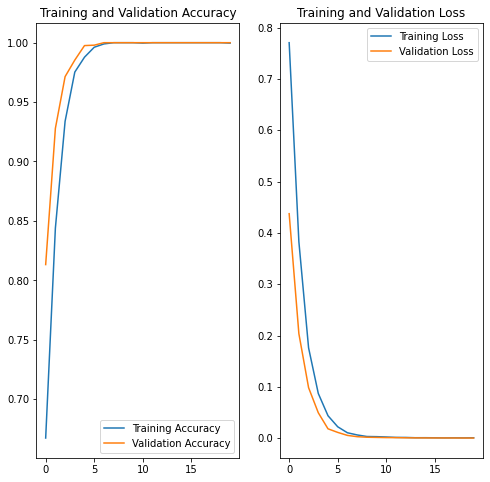

<Figure size 432x288 with 0 Axes>

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_8.png')

Batch Size = 64

In [121]:
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)



Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [122]:
model_9 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [123]:
model_9.compile(optimizer= 'Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [124]:
model_9.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 254, 254, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 31, 31, 64)      

In [125]:
epochs=20
history = model_9.fit(
  train_ds,
  validation_data=train_ds,
  epochs=epochs
  
)

Epoch 1/20
45/45 [==============================] - 19s 358ms/step - loss: 1.3658 - accuracy: 0.4179 - val_loss: 0.7096 - val_accuracy: 0.7070
Epoch 2/20
45/45 [==============================] - 16s 350ms/step - loss: 0.6476 - accuracy: 0.7280 - val_loss: 0.5228 - val_accuracy: 0.7937
Epoch 3/20
45/45 [==============================] - 17s 351ms/step - loss: 0.4966 - accuracy: 0.7900 - val_loss: 0.3017 - val_accuracy: 0.8899
Epoch 4/20
45/45 [==============================] - 17s 350ms/step - loss: 0.3118 - accuracy: 0.8773 - val_loss: 0.2276 - val_accuracy: 0.9247
Epoch 5/20
45/45 [==============================] - 16s 349ms/step - loss: 0.2357 - accuracy: 0.9145 - val_loss: 0.1391 - val_accuracy: 0.9652
Epoch 6/20
45/45 [==============================] - 17s 352ms/step - loss: 0.1621 - accuracy: 0.9472 - val_loss: 0.1137 - val_accuracy: 0.9794
Epoch 7/20
45/45 [==============================] - 17s 352ms/step - loss: 0.1242 - accuracy: 0.9674 - val_loss: 0.0725 - val_accuracy: 0.9861

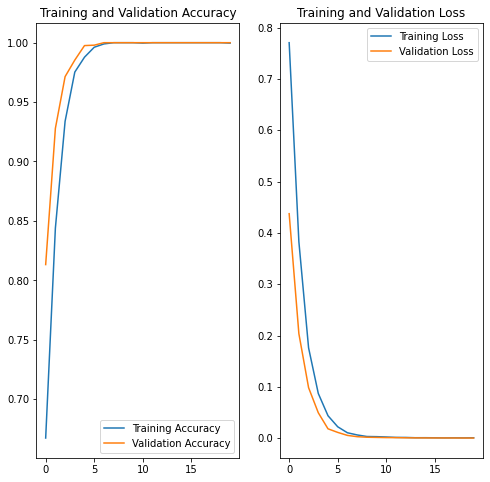

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=10,
    image_size=(img_height, img_width),
    batch_size= batch_size
)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('model_8.png')